In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from keras.callbacks import EarlyStopping
import sklearn.feature_extraction.text as sk_text



In [ ]:
#I did this in separate ipynb file but I think I have to submit all code 
#in one file so I copy pasted 

##load the business data using chunk and remove unnecessary columns and saved it as csv
col_not =["address","city","latitude","longitude","review_count","is_open","attributes","categories","hours","postal_code"]
b_pandas=[]
with open("./yelp_dataset/yelp_academic_dataset_business.json","r",encoding="utf-8") as f:
    reader = pd.read_json(f,lines=True,chunksize=1000)
    
    for chunck in reader: 
        reduced_chunk = chunck.drop(columns=col_not)
        b_pandas.append(reduced_chunk)

b_pandas = pd.concat(b_pandas,ignore_index=True)
b_pandas.to_csv("./files/Cleaned_business.csv",index=False)

In [ ]:
#I did this in separate ipynb file but I think I have to submit all code 
#in one file so I copy pasted 

## load the review json file and remove unnecessary columns and 
# choose business with more than 20 reviews and saved it as csv
# business_dataset = pd.read_json("./yelp_dataset/yelp_academic_dataset_business.json")
from numpy import datetime64
from pandas import Int32Dtype, StringDtype
b_pandas =[]
not_needed=["review_id","user_id","useful","funny","cool"]
r_dtypes = {
    "review_id": StringDtype,
     "user_id" : StringDtype,
     "business_id": StringDtype,
     "stars":Int32Dtype,
     "date": datetime64,
     "text":StringDtype,
     "useful":Int32Dtype,
     "funny" :Int32Dtype,
     "cool":Int32Dtype     
}
with open("./yelp_dataset/yelp_academic_dataset_review.json","r",encoding="utf-8") as f:
    reader = pd.read_json(f,orient="records",lines=True,dtype=r_dtypes,chunksize=1000)
    
    for chunck in reader: 
        reduced_chunk = chunck.drop(columns=not_needed)
        b_pandas.append(reduced_chunk)

b_pandas = pd.concat(b_pandas,ignore_index=True)

# 1. Group by businesss id to see the count of reviews for each business 
# 2. Filter them (count >=20) as per our requirement
# 3.Inner join it with full review data so that we get full reviews 
# 4.ALL the reviews by each business and create a new dataframe, where each line
#   is a business with all its reviews aggregated together.

df = b_pandas.groupby("business_id")["business_id"].count().reset_index(name='counts')
df = df[df["counts"] >= 20 ]
b_pandas = df.merge(b_pandas,how="inner",on="business_id",suffixes=None)

df_review_agg = b_pandas.groupby("business_id")["text"].sum()
df_ready = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews':
df_review_agg.values})
df_ready.to_csv("./files/Cleaned_review.csv",index=False)

In [5]:
# First Convert the text into tfidfvecotrizer 
review_dataset = pd.read_csv("./files/Cleaned_review.csv")



In [6]:

# merged_dataset = business_dataset.merge(how="inner",on="business_id",suffixes=None)
vectorizer = sk_text.TfidfVectorizer(max_features=1200,stop_words='english',min_df=50)
matrix = vectorizer.fit_transform(review_dataset["all_reviews"])

In [7]:
tfidf = matrix.toarray()
tfidf.shape

(63489, 1200)

In [8]:
temp_review_dataset = review_dataset.drop(["all_reviews"],axis=1)


In [9]:
temp_review_dataset["tfidf"] = list(tfidf)
temp_review_dataset.head(5)

,business_id,tfidf
0,---kPU91CF4Lq2-WlRu9Lw,"[0.0, 0.014920119710781334, 0.0, 0.0, 0.0, 0.0..."
1,--8IbOsAAxjKRoYsBFL-PA,"[0.017335475408387653, 0.0349019381389179, 0.0..."
2,--9osgUCSDUWUkoTLdvYhQ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0120453502451..."
3,--ARBQr1WMsTWiwOKOj-FQ,"[0.0, 0.022418272508495585, 0.0, 0.0, 0.0, 0.0..."
4,--FcbSxK1AoEtEAxOgBaCw,"[0.0, 0.01363918706287604, 0.0, 0.007222799765..."


In [22]:
temp_review_dataset.to_csv("./files/tfidf.csv",index=False)

In [10]:
business_dataset = pd.read_csv("./files/Cleaned_business.csv")


In [11]:
combined_dataset = business_dataset.merge(temp_review_dataset,how="inner",on="business_id")

In [12]:
combined_dataset.shape

(63489, 5)

In [13]:
vectors_for_training = np.array(combined_dataset["tfidf"].tolist())
five_business = combined_dataset.sample(n=5)


In [56]:
#split the dataset 
X_train,X_test,y_train,y_test = train_test_split(vectors_for_training,combined_dataset["stars"],test_size=0.25,random_state=42)


In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(47616, 1200)
(15873, 1200)
(47616,)
(15873,)


In [17]:
#create the model 
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
def my_model(n_hidden = 1,n_neurons = 30,activation="relu",optimizer="adam"):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation=activation))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mean_squared_error",optimizer=optimizer)
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(my_model)

params = {
    "n_hidden":[1,2,3],
    "n_neurons":np.arange(1,50),
    "activation":["relu","sigmoid","tanh"],
    "optimizer" : ["adam","sgd"]
}

monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')
rnd_search_cv = RandomizedSearchCV(keras_reg,params,n_iter=10,cv=3)
rnd_search_cv.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),callbacks=monitor)
    

C:\Users\Rojan\AppData\Local\Temp\ipykernel_113104\2755934457.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(my_model)


Epoch 1/100
992/992 [==============================] - 1s 1ms/step - loss: 0.7697 - val_loss: 0.7185
Epoch 2/100
992/992 [==============================] - 1s 1ms/step - loss: 0.7198 - val_loss: 0.7479
Epoch 3/100
992/992 [==============================] - 1s 1ms/step - loss: 0.7200 - val_loss: 0.7184
Epoch 3: early stopping
496/496 [==============================] - 0s 697us/step - loss: 0.7093
Epoch 1/100
992/992 [==============================] - 1s 1ms/step - loss: 0.7420 - val_loss: 0.7433
Epoch 2/100
992/992 [==============================] - 1s 1ms/step - loss: 0.7169 - val_loss: 0.7166
Epoch 3/100
992/992 [==============================] - 1s 1ms/step - loss: 0.7164 - val_loss: 0.7198
Epoch 4/100
992/992 [==============================] - 1s 1ms/step - loss: 0.7165 - val_loss: 0.7179
Epoch 4: early stopping
496/496 [==============================] - 0s 703us/step - loss: 0.7162
Epoch 1/100
992/992 [==============================] - 1s 1ms/step - loss: 0.7519 - val_loss: 0.7187


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001BADAF27430>,
                   param_distributions={'activation': ['relu', 'sigmoid',
                                                       'tanh'],
                                        'n_hidden': [1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'optimizer': ['adam', 'sgd']})

In [19]:
rnd_search_result = pd.DataFrame.from_dict(rnd_search_cv.cv_results_)
r = rnd_search_result.sort_values(by="rank_test_score").head(10)
rnd_search_result_top = r[["params","mean_test_score","mean_score_time","rank_test_score"]]

In [22]:
pd.set_option("display.max_colwidth",None)
rnd_search_result_top

,params,mean_test_score,mean_score_time,rank_test_score
2,"{'optimizer': 'adam', 'n_neurons': 10, 'n_hidden': 2, 'activation': 'tanh'}",-0.069161,0.499983,1
8,"{'optimizer': 'adam', 'n_neurons': 32, 'n_hidden': 3, 'activation': 'tanh'}",-0.069705,0.544801,2
6,"{'optimizer': 'adam', 'n_neurons': 35, 'n_hidden': 2, 'activation': 'relu'}",-0.080512,0.538780,3
4,"{'optimizer': 'sgd', 'n_neurons': 25, 'n_hidden': 2, 'activation': 'relu'}",-0.083651,0.474658,4
1,"{'optimizer': 'sgd', 'n_neurons': 16, 'n_hidden': 2, 'activation': 'relu'}",-0.087121,2.440437,5
3,"{'optimizer': 'sgd', 'n_neurons': 41, 'n_hidden': 2, 'activation': 'relu'}",-0.087733,0.535118,6
7,"{'optimizer': 'sgd', 'n_neurons': 16, 'n_hidden': 2, 'activation': 'tanh'}",-0.096592,0.498639,7
5,"{'optimizer': 'sgd', 'n_neurons': 29, 'n_hidden': 1, 'activation': 'tanh'}",-0.102232,0.476695,8
9,"{'optimizer': 'sgd', 'n_neurons': 36, 'n_hidden': 1, 'activation': 'sigmoid'}",-0.112594,0.657648,9
0,"{'optimizer': 'sgd', 'n_neurons': 25, 'n_hidden': 3, 'activation': 'sigmoid'}",-0.715673,0.409699,10


In [23]:
print(f"The best Parameters are : {rnd_search_cv.best_params_} and the best score is {rnd_search_cv.best_score_}" )

The best Parameters are : {'optimizer': 'adam', 'n_neurons': 10, 'n_hidden': 2, 'activation': 'tanh'} and the best score is -0.0691614697376887


In [24]:
model = rnd_search_cv.best_estimator_.model

In [57]:
# Predict and measure RMSE
pred = model.predict(X_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
# chart_regression(pred,y_test, sort=True)

497/497 [==============================] - 0s 572us/step
Score (RMSE): 0.25923101416319866


In [80]:
#Some Helpful functions from Lab
# Regression chart.
def chart_regression(pred,y,sort=True):
    # s = y.to_frame(name="y")
    t = pd.DataFrame({'pred' : pred,'y':y.flatten()})
    # t = pd.concat([s,f],axis = "columns")
    # print(t.head(10))
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


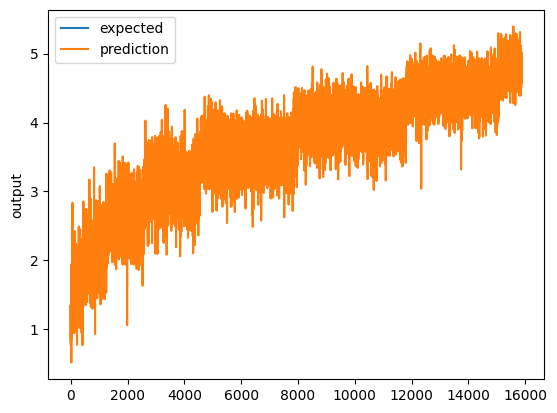

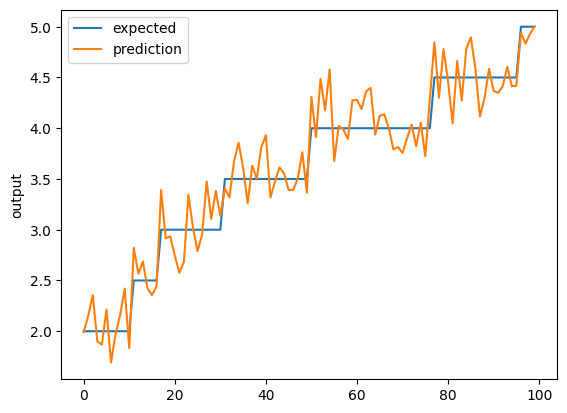

In [82]:
chart_regression(pred.flatten(),y_test.values.reshape(15873,1),True)
chart_regression(pred.flatten()[:100],y_test.values.reshape(15873,1)[:100],True)

In [84]:
vectors = np.array(five_business["tfidf"].tolist())
predict_five = model.predict(vectors)

1/1 [==============================] - 0s 13ms/step


In [89]:
t = pd.DataFrame({'pred' : predict_five.flatten()})


In [93]:
rep = five_business[["name","stars"]]

In [97]:
rep.reset_index(drop=True,inplace=True)
rep

,name,stars
0,Comfort Inn Philadelphia Airport,2.0
1,Llywelyn's Pub,3.5
2,Anniversary Inn Boise,4.0
3,Taco Tico,3.5
4,Whiskey River On The Water,3.5


In [99]:
rep = pd.concat([rep,t],axis='columns')

In [100]:
rep

,name,stars,pred
0,Comfort Inn Philadelphia Airport,2.0,2.219936
1,Llywelyn's Pub,3.5,3.515901
2,Anniversary Inn Boise,4.0,4.237479
3,Taco Tico,3.5,3.758173
4,Whiskey River On The Water,3.5,3.522271
